# Block Based Motion Estimation

In [1]:
import numpy as np
import frame
import YCoCg as YUV
import motion
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import LP
import cv2 as cv

config.py: n_frames=36
config.py: input_video=/tmp/original_
config.py: codestream=/tmp/codestream_
config.py: output_video=/tmp/reconstructed_
config.py: nsrl=5 (number of spatial resolution levels)
config.py: fps=30 (frames per second)
config.py: subpixel_accuracy=1
OFCA extension mode = 1


In [2]:
def normalize(img):
    max_component = np.max(img)
    min_component = np.min(img)
    max_min_component = max_component - min_component
    return (img-min_component)/max_min_component

def show_frame(frame, prefix=None):
    #frame = normalize(frame)
    plt.figure(figsize=(10,10))
    plt.title(prefix, fontsize=20)
    plt.imshow(frame)

In [3]:
R = YUV.from_RGB(frame.read("../sequences/moving_circle/", 0))[...,0]
P = YUV.from_RGB(frame.read("../sequences/moving_circle/", 1))[...,0]

frame.read: reading ../sequences/moving_circle/000.png (64, 64, 3) uint8 641 
frame.read: reading ../sequences/moving_circle/001.png (64, 64, 3) uint8 641 


In [4]:
flow = motion.estimate(P, R)

In [5]:
flow.shape

(64, 64, 2)

In [6]:
flow.min()

-0.9999926

In [7]:
for i in range(64):
    for j in range(64):
        print((np.rint(flow)[i,j][1]), end=' ')
    print()

0.0 0.0 0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 
0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 
-0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -

-0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 0.0 0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 -0.0 -0.0 0.0 0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 
-0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 0.0 0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 -0.0 -0.0 -0.0 0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 0.0 -0.0 -0.0 -0.0 
-0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 0.0 0.0 -0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 -0.0 -0.0 0.0 0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 0.0 -0.0 -0.0 0.0 0.0 0.0 
-0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 

frame.read: reading ../sequences/moving_circle/000.png (64, 64, 3) uint8 641 
frame.read: reading ../sequences/moving_circle/001.png (64, 64, 3) uint8 641 


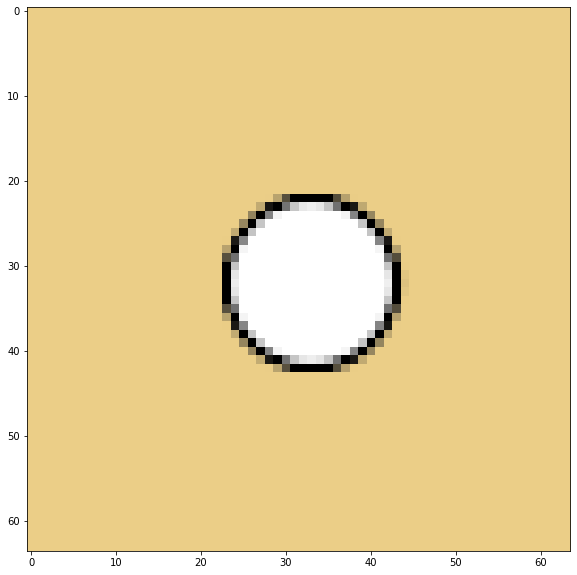

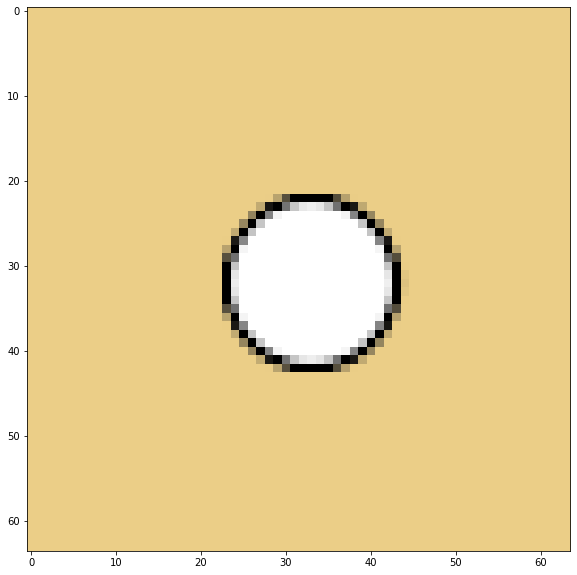

In [8]:
R = frame.read("../sequences/moving_circle/", 0)
P = frame.read("../sequences/moving_circle/", 1)
prediction = motion.make_prediction(R, flow)
show_frame(prediction)
show_frame(P)

In [9]:
R = YUV.from_RGB(frame.read("../sequences/moving_circle/", 0))[...,0]
P = YUV.from_RGB(frame.read("../sequences/moving_circle/", 1))[...,0]

frame.read: reading ../sequences/moving_circle/000.png (64, 64, 3) uint8 641 
frame.read: reading ../sequences/moving_circle/001.png (64, 64, 3) uint8 641 


In [10]:
#      5       3       8
#      1       0       2
#      7       4       6
# (-1,-1) (-1, 0) (-1, 1)
# ( 0,-1) ( 0, 0) ( 0, 1)
# ( 1,-1) ( 1, 0) ( 1, 1)
#spiral  = np.array([(-1,-1), (-1, 1), ( 1,-1), ( 1, 1), (-1, 0), ( 1, 0), ( 0,-1), ( 0, 1), ( 0, 0)])
spiral  = np.array([( 0, 0), (-1,-1), (-1, 1), ( 1,-1), ( 1, 1), (-1, 0), ( 1, 0), ( 0,-1), ( 0, 1)])
spiral  = np.array([( 0, 0), ( 0,-1), ( 0, 1), (-1, 0), ( 1, 0), (-1,-1), ( 1, 1), ( 1,-1), (-1, 1)])

# (0,0) (0,1) (0,2)
# (1,0) (1,1) (1,2)
# (2,0) (2,1) (2,2)
spiral_ = np.array([( 1, 1), ( 0, 0), ( 0, 2), ( 2, 0), ( 2, 2), ( 0, 1), ( 2, 1), ( 1, 0), ( 1, 2)])
spiral_ = np.array([( 1, 1), ( 1, 0), ( 1, 2), ( 0, 1), ( 2, 1), ( 0, 0), ( 2, 2), ( 2, 0), ( 0, 2)])

In [11]:
# (x, y)
#      5       3       8
#      1       0       2
#      7       4       6
# (-1,-1) ( 0,-1) ( 1,-1)
# (-1, 0) ( 0, 0) ( 1, 0)
# (-1, 1) ( 0, 1) ( 1, 1)
spiral  = np.array([( 0, 0), (-1, 0), ( 1, 0), ( 0,-1), ( 0, 1), (-1,-1), ( 1, 1), (-1, 1), ( 1,-1)], dtype=np.int16)
#                        0        1        2        3        4        5        6        7        8

# (0,0) (1,0) (2,0)
# (0,1) (1,1) (2,1)
# (0,2) (1,2) (2,2)
spiral_ = np.array([( 1, 1), ( 0, 1), ( 2, 1), ( 1, 0), ( 1, 2), ( 0, 0), ( 2, 2), ( 0, 2), ( 2, 0)], dtype=np.int16)

In [12]:
print(spiral.dtype)

int16


In [13]:
extended_R = np.zeros((R.shape[0]+2, R.shape[1]+2))
extended_R[1:R.shape[0]+1, 1:R.shape[1]+1] = R

In [14]:
extended_R = np.pad(R, (1, 1), 'edge')

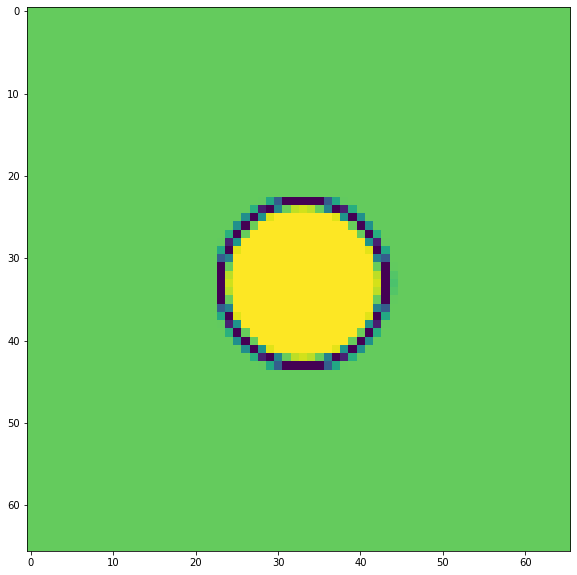

In [15]:
show_frame(extended_R)

In [16]:
D = np.zeros((P.shape[0], P.shape[1], 9), dtype=np.float32)

In [17]:
for i in range(9):
    diff = extended_R[spiral_[i][1]:R.shape[0]+spiral_[i][1], spiral_[i][0]:R.shape[1]+spiral_[i][0]] - P
    D[:,:,i] = diff*diff

In [18]:
print(D[0,0,0], D[0,0,1], D[0,0,2], D[0,0,3])

0.0 0.0 0.0 0.0


0.0


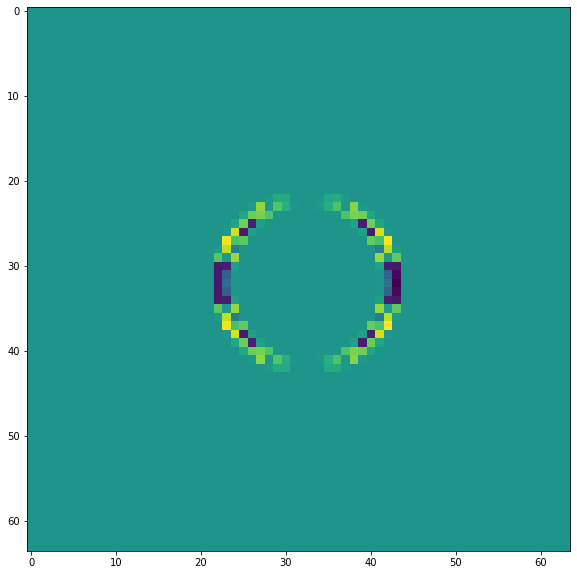

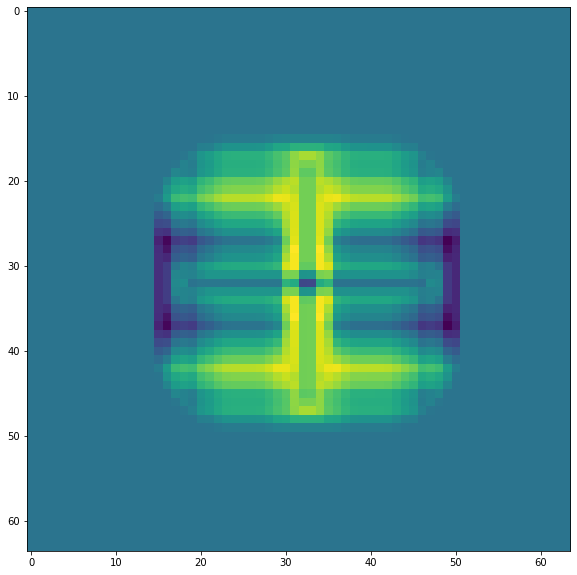

In [19]:
DD = np.empty_like(D).astype(np.float32)
DD[...] = D
print(D[0,0,1])
show_frame(D[...,0])
kernel = np.ones((15,15),np.float32)/(15*15)
D = cv.filter2D(DD,-1,kernel)
#show_frame(D[...,0]+D[...,1])
show_frame(np.rint(D[...,0]))


In [23]:
flow_indexes = np.argmin(np.rint(D), axis=2)
for i in range(64):
    for j in range(64):
        print(flow_indexes[i,j], end='')
    print()

0000000000000000000000000000000000000000000000000000000000000000
0000000000000000000000000000000000000000000000000000000000000000
0000000000000000000000000000000000000000000000000000000000000000
0000000000000000000000000000000000000000000000000000000000000000
0000000000000000000000000000000000000000000000000000000000000000
0000000000000000000000000000000000000000000000000000000000000000
0000000000000000000000000000000000000000000000000000000000000000
0000000000000000000000000000000000000000000000000000000000000000
0000000000000000000000000000000000000000000000000000000000000000
0000000000000000000000000000000000000000000000000000000000000000
0000000000000000000000000000000000000000000000000000000000000000
0000000000000000000000000000000000000000000000000000000000000000
0000000000000000000000000000000000000000000000000000000000000000
0000000000000000000000000000000000000000000000000000000000000000
0000000000000000000000666664774444466477777000000000000000000000
0000000000000000000001166

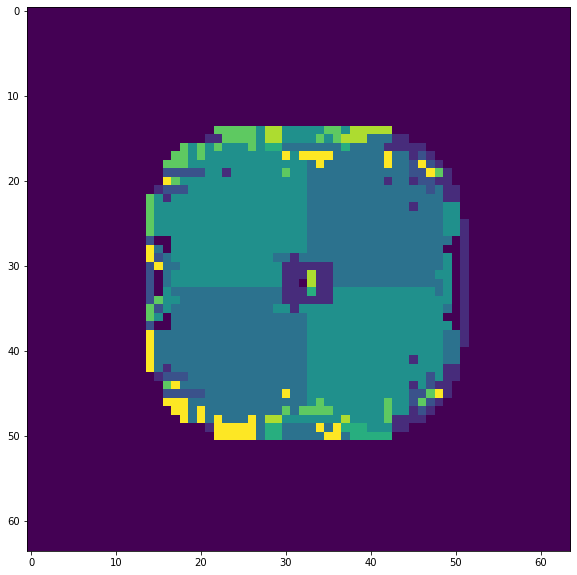

In [21]:
show_frame(flow_indexes)

In [22]:
print(D[0,0,0], D[0,0,1], D[0,0,2], D[0,0,3])

7.7182706e-14 0.0 4.2144067e-14 2.90612e-14


In [24]:
flow = spiral[flow_indexes]

In [25]:
for i in range(64):
    for j in range(64):
        print(flow[i,j][1], end=' ')
    print()

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [ ]:
show_frame(D[:,:,1] - D[:,:,8])

In [26]:
R = frame.read("../sequences/moving_circle/", 0)

frame.read: reading ../sequences/moving_circle/000.png (64, 64, 3) uint8 641 


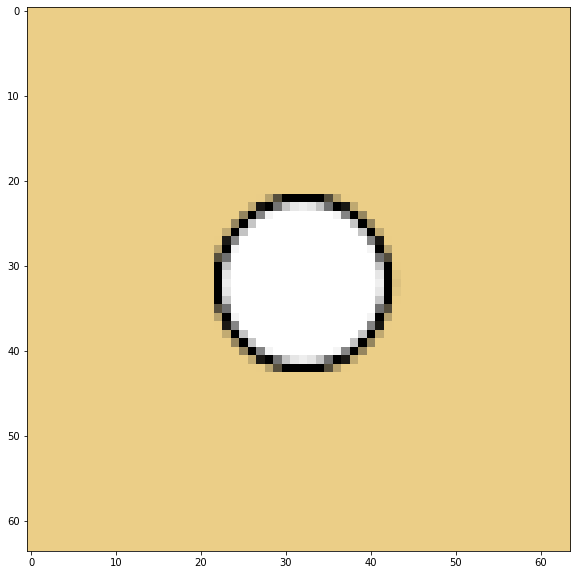

In [27]:
show_frame(R)

In [28]:
prediction = motion.make_prediction(R, flow.astype(np.float32))

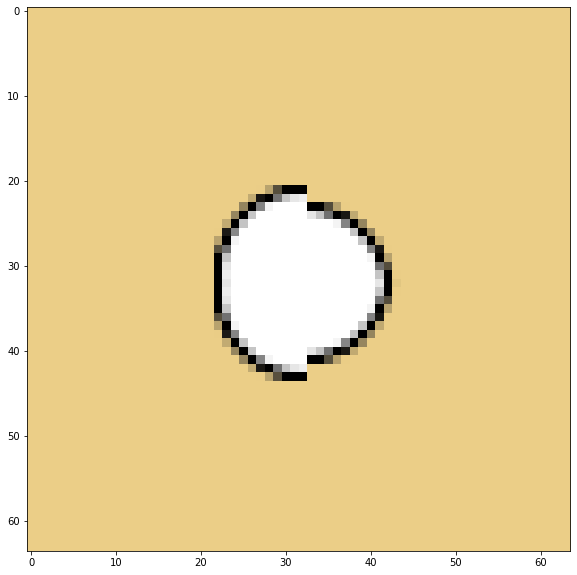

In [29]:
show_frame(prediction)

frame.read: reading ../sequences/moving_circle/001.png (64, 64, 3) uint8 641 


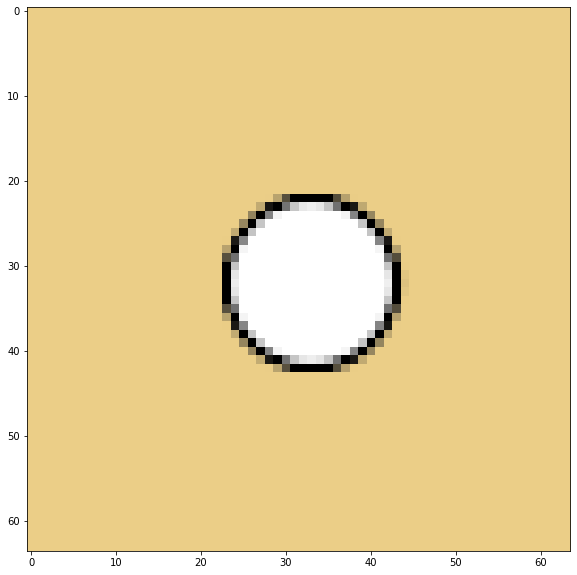

In [30]:
P = frame.read("../sequences/moving_circle/", 1)
show_frame(P)

In [ ]:
R = YUV.from_RGB(frame.read("../sequences/moving_circle/", 0))
P = YUV.from_RGB(frame.read("../sequences/moving_circle/", 1))

In [ ]:
def spiral_estimate(P, R, window_side=15):
    extended_R = np.zeros((R.shape[0]+2, R.shape[1]+2))
    extended_R[1:R.shape[0]+1, 1:R.shape[1]+1] = R
    D = np.zeros((P.shape[0], P.shape[1], 9), dtype=np.float32)
    for i in range(9):
        diff = extended_R[spiral_[i][1]:R.shape[0]+spiral_[i][1], spiral_[i][0]:R.shape[1]+spiral_[i][0]] - P
        D[:,:,i] = diff*diff
    # Tenemos la distancia L2, pixel-wise, para cada posible desplazamiento de ambas matrices, R y P.
    # Ahora se trata de encontrar una nueva matriz de distancias donde se tenga en cuenta las distancias adyacentes.
    DD = np.empty_like(D).astype(np.float32)
    DD[...] = D
    kernel = np.ones((window_side,window_side),np.float32)/(window_side*window_side)
    D = cv.filter2D(DD,-1,kernel)
    #show_frame(D[...,0]+D[...,1])
    show_frame(D[...,0])
    #for y in range(D.shape[0]):
    #    for x in range(D.shape[1]):
    #        print(D[y,x], end=' ')
    #    print()
    #print(80*"=")
    flow_indexes = np.argmin(D, axis=2)
    for i in range(flow_indexes.shape[0]):
        for j in range(flow_indexes.shape[1]):
            print(flow_indexes[i,j], end=' ')
        print()
    print(80*"=")
    flow = spiral[flow_indexes]
    return flow

In [ ]:
def spiral_estimate2(initial_flow, P, R, window_side=15):
    extended_R = np.zeros((R.shape[0]+2, R.shape[1]+2))
    extended_R[1:R.shape[0]+1, 1:R.shape[1]+1] = R
    D = np.zeros((P.shape[0], P.shape[1], 9), dtype=np.float32)
    for i in range(9):
        
        diff = extended_R[initial_flow[1]+spiral_[i][1]:R.shape[0]+spiral_[i][1], spiral_[i][0]:R.shape[1]+spiral_[i][0]] - P
        D[:,:,i] = diff*diff
    # Tenemos la distancia L2, pixel-wise, para cada posible desplazamiento de ambas matrices, R y P.
    # Ahora se trata de encontrar una nueva matriz de distancias donde se tenga en cuenta las distancias adyacentes.
    DD = np.empty_like(D).astype(np.float32)
    DD[...] = D
    kernel = np.ones((window_side,window_side),np.float32)/(window_side*window_side)
    D = cv.filter2D(DD,-1,kernel)
    #show_frame(D[...,0]+D[...,1])
    show_frame(D[...,0])
    #for y in range(D.shape[0]):
    #    for x in range(D.shape[1]):
    #        print(D[y,x], end=' ')
    #    print()
    #print(80*"=")
    flow_indexes = np.argmin(D, axis=2)
    for i in range(flow_indexes.shape[0]):
        for j in range(flow_indexes.shape[1]):
            print(flow_indexes[i,j], end=' ')
        print()
    print(80*"=")
    flow = initial_flow + spiral[flow_indexes]
    return flow

In [ ]:
flow = spiral_estimate(P[...,0], R[...,0])

In [ ]:
for i in range(64):
    for j in range(64):
        print(flow[i,j][0], end=' ')
    print()

In [ ]:
def estimate(P, R, log2_search_area, n_levels):
    if log2_search_area > 0:
        P_pyramid = LP.analyze(P, log2_search_area)
        R_pyramid = LP.analyze(R, log2_search_area)
    else:
        P_pyramid = [P]
        R_pyramid = [R]
    #total_flow = np.zeros(((R_pyramid[0].shape[0]+1)//2, (R_pyramid[0].shape[1]+1)//2, 2), dtype=np.int16)
    total_flow = np.zeros((R_pyramid[0].shape[0], R_pyramid[0].shape[1], 2), dtype=np.int16)
    for l in range(n_levels):
        _R_pyramid = motion.make_prediction(R_pyramid[l], total_flow.astype(np.float32))
        flow = spiral_estimate(P_pyramid[l], _R_pyramid)
        total_flow *= 2
        total_flow += flow
        total_flow = total_flow.astype(np.int16)
        #for y in range(total_flow.shape[0]):
        #    for x in range(total_flow.shape[1]):
        #        print(total_flow[y,x], end=' ')
        #    print()
        #print(80*"=")
        #show_frame(R_pyramid[l+1])
        R_pyramid[l+1] = LP.synthesize_step(R_pyramid[l], R_pyramid[l+1])
        P_pyramid[l+1] = LP.synthesize_step(P_pyramid[l], P_pyramid[l+1])
        total_flow = LP.synthesize_step(total_flow.astype(np.float32), np.zeros(total_flow.shape)).astype(np.int16)
    _R = motion.make_prediction(R, total_flow.astype(np.float32))
    flow = spiral_estimate(P, _R)
    if log2_search_area > 0:
        #total_flow = LP.synthesize_step(total_flow.astype(np.float32), np.zeros(total_flow.shape)).astype(np.int16)
        #total_flow *= 2
        total_flow += flow
        total_flow = total_flow.astype(np.int16)
    else:
        return flow
    return total_flow

In [ ]:
flow = estimate(P[...,0], R[...,0], 1, 1)

In [ ]:
for i in range(64):
    for j in range(64):
        print(flow[i,j][0], end=' ')
    print()

In [ ]:
show_frame(flow[...,0])

In [ ]:
show_frame(flow[...,1])

In [ ]:
R = frame.read("../sequences/moving_circle/", 0)
P = frame.read("../sequences/moving_circle/", 1)

In [ ]:
prediction = motion.make_prediction(R, flow.astype(np.float32))

In [ ]:
show_frame(prediction)

In [ ]:
show_frame(P)

In [ ]:
show_frame(R)

In [ ]:
show_frame(prediction-P)

In [ ]:
frame.write(prediction, "/tmp/pred", 0)

In [ ]:
############################3

In [ ]:
D = []
for i in _spiral:
    difference = extended_R[i[0]:R.shape[0]+i[0], i[1]:R.shape[1]+i[1]] - P
    D.append(difference)

In [ ]:
D[1].max()